# Script to evaluate the ML-Models

Setup (load automl-models.pickle)

In [1]:
import pickle
import csv

with open(r"../app/_meta.csv") as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  list_qualities = list()
  for line in csv_reader:
    list_qualities.append(line[0])
  list_qualities = list_qualities[1:]


with open(r"../app/ml-models.pickle", "rb") as input_file:
  ml_models = pickle.load(input_file)

Inspect the score:

In [2]:
sum_scores = 0
for key, value in ml_models.items():
  print(key, ':', value.get('score'))
  sum_scores += value.get('score')
print()
print('Average:', "{:.2f}".format(100*sum_scores/len(ml_models), 2), '%')

TPOT : 0.85
auto-sklearn : 0.95
Hyperopt-Sklearn : 0.95
H2O AutoML : 0.85
FLAML : 0.6
AutoGluon : 1.0
ATM : 0.75
TransmogrifAI : 1.0

Average: 86.88 %


Test with a random dataset:

In [3]:
import openml as oml
import pandas as pd

In [4]:
dataset = oml.datasets.get_dataset(12)

In [5]:
t = dict()

for quality in list_qualities:
  t[quality] = [dataset.qualities.get(quality)]
test_df = pd.DataFrame(t)

for key, value in ml_models.items():
  aml = value.get('model')
  print(key, ':', aml.predict(test_df))

TPOT : [0]
auto-sklearn : [0]
Hyperopt-Sklearn : [0]
H2O AutoML : [0]
FLAML : [1]
AutoGluon : [0]
ATM : [1]
TransmogrifAI : [0]


In [6]:
for key, value in ml_models.items():
  aml = value.get('model')
  print(key, ':', aml.best_estimator)

TPOT : lgbm
auto-sklearn : lgbm
Hyperopt-Sklearn : xgboost
H2O AutoML : lgbm
FLAML : xgb_limitdepth
AutoGluon : rf
ATM : lgbm
TransmogrifAI : lgbm


In [7]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

results = dict()

for key in ml_models.keys():
  ml_model_dict = ml_models.get(key)
  model, X, y = ml_model_dict.get('model'), ml_model_dict.get('X'), ml_model_dict.get('y')
  np.nan_to_num(X)
  result = permutation_importance(model,
                                X,
                                y,
                                n_repeats=10,
                                random_state=42,
                                n_jobs=-1)
  results[key] = result

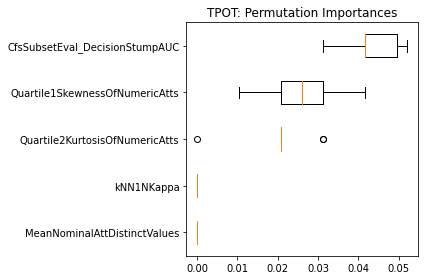

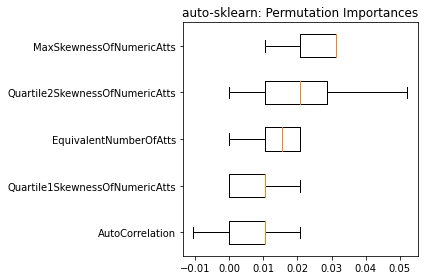

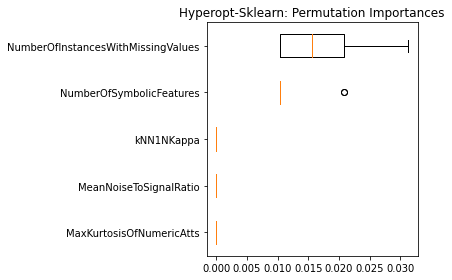

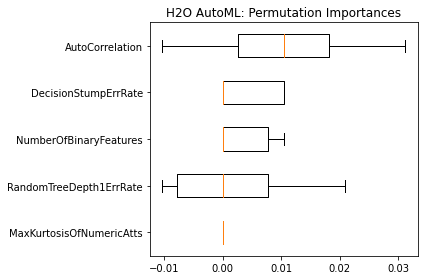

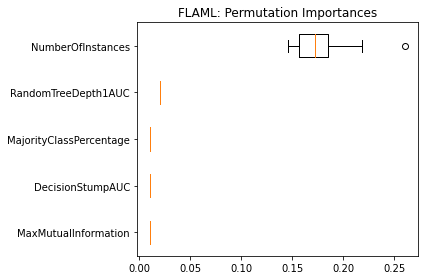

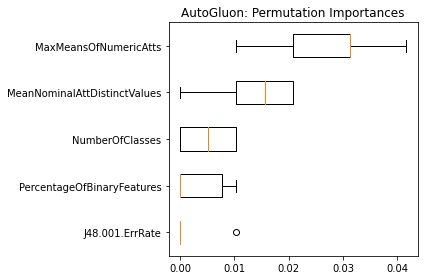

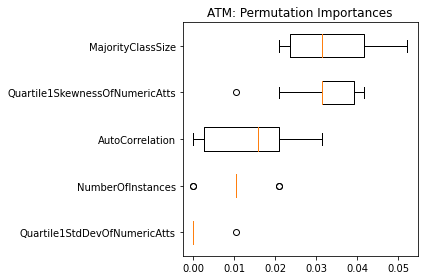

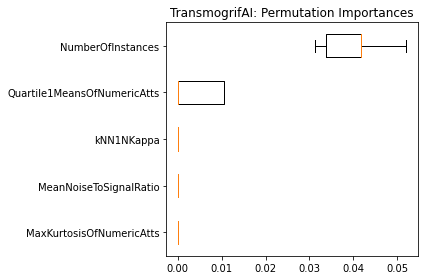

In [16]:
import matplotlib.pyplot as plt

for key, result in results.items(): 
  sorted_idx = result.importances_mean.argsort()[-5:]      
  fig, ax = plt.subplots()
  ax.boxplot(result.importances[sorted_idx].T,
           vert=False,
           labels=X.columns[sorted_idx])

  ax.set_title(key + ": Permutation Importances")
  fig.tight_layout()
  plt.savefig('graphs/' + key + '-features.png', dpi=300)